# Comparison of Classification Models for Delay Prediction

This notebook provides a comprehensive framework for predicting delays (e.g., supply chain, transport, flight). 
We compare multiple machine learning models from baselines to advanced ensembles, analyzing them locally with technical metrics and contextual business costs.

**Structure:**
1. **Setup**: Environment and library configuration.
2. **Data Generation**: Creating a realistic synthetic dataset.
3. **EDA**: Visualizing distributions and correlations.
4. **Feature Engineering**: Processing data for ML readiness.
5. **Modeling**: Training Logistic Regression, RF, SVM, XGBoost, etc.
6. **Evaluation**: Detailed metrics, ROC/PR curves, and Confusion Matrices.
7. **Business Analysis**: Cost-benefit analysis and threshold optimization.
8. **Summary**: Final recommendations.

In [1]:
# Core Data Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Preprocessing & Selection
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Machine Learning - Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Machine Learning - Metrics
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, f1_score, accuracy_score, 
    precision_score, recall_score, average_precision_score
)

# Warnings & Settings
import warnings
warnings.filterwarnings('ignore')

sns.set_palette("husl")
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

## 2. Data Generation & Exploration

We will generate a synthetic dataset simulating logistics delivery.

**Features:**
- **Distance**: Miles to destination.
- **Time_of_Day**: Hour of scheduled departure (0-23).
- **Day_of_Week**: Mon-Sun.
- **Weather**: Clear, Rain, Snow, Fog.
- **Traffic**: Low, Medium, High.
- **Priority**: Hazard (Critical), Express, Standard.

**Target:**
- **Delay_Status**: 0 (On-Time), 1 (Delayed).

In [2]:
def generate_delay_data(n_samples=2000, random_state=42):
    np.random.seed(random_state)
    
    # 1. Generate Raw Features
    distance = np.abs(np.random.normal(loc=400, scale=250, size=n_samples)) # Skewed normal
    time_of_day = np.random.randint(0, 24, size=n_samples)
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    day_of_week = np.random.choice(days, size=n_samples)
    weather_opts = ['Clear', 'Rain', 'Snow', 'Fog']
    weather = np.random.choice(weather_opts, size=n_samples, p=[0.65, 0.2, 0.1, 0.05])
    traffic_opts = ['Low', 'Medium', 'High']
    traffic = np.random.choice(traffic_opts, size=n_samples, p=[0.4, 0.4, 0.2])
    priority_opts = ['Standard', 'Express', 'Critical']
    priority = np.random.choice(priority_opts, size=n_samples, p=[0.6, 0.3, 0.1])
    
    df = pd.DataFrame({
        'Distance': distance,
        'Time_of_Day': time_of_day,
        'Day_of_Week': day_of_week,
        'Weather': weather,
        'Traffic': traffic,
        'Priority': priority
    })
    
    # 2. Define Probabilistic Logic for Delay
    # Base log-odds
    logit = -2.0 
    
    # Additive effects
    logit += (df['Distance'] / 600.0)  # Longer distance -> higher delay
    
    # Rush hours (7-9am, 4-6pm) increase delay
    is_rush = df['Time_of_Day'].isin([7,8,9, 16,17,18])
    logit += np.where(is_rush, 1.2, 0)
    
    # Weather impacts
    logit += np.where(df['Weather'] == 'Snow', 1.5, 0)
    logit += np.where(df['Weather'] == 'Rain', 0.8, 0)
    logit += np.where(df['Weather'] == 'Fog', 0.5, 0)
    
    # Traffic impacts
    logit += np.where(df['Traffic'] == 'High', 1.0, 0)
    logit += np.where(df['Traffic'] == 'Medium', 0.4, 0)
    
    # Priority (Express/Critical get handled faster?)
    logit -= np.where(df['Priority'] == 'Critical', 0.8, 0)
    logit -= np.where(df['Priority'] == 'Express', 0.4, 0)
    
    # Add random noise
    logit += np.random.normal(0, 0.5, size=n_samples)
    
    # Sigmoid to probability
    prob = 1 / (1 + np.exp(-logit))
    
    # Target assignment
    df['Delay_Status'] = (np.random.random(n_samples) < prob).astype(int)
    
    # Create a Readable Label
    df['Delay_Label'] = df['Delay_Status'].map({0: 'On-Time', 1: 'Delayed'})
    
    return df

# Generate Data
df = generate_delay_data(n_samples=2000)
print(f"DataFrame Shape: {df.shape}")
df.head()

DataFrame Shape: (2000, 8)


,Distance,Time_of_Day,Day_of_Week,Weather,Traffic,Priority,Delay_Status,Delay_Label
0,524.178538,5,Fri,Snow,High,Standard,1,Delayed
1,365.433925,10,Sun,Clear,Low,Express,1,Delayed
2,561.922135,2,Sat,Clear,High,Express,1,Delayed
3,780.757464,7,Tue,Clear,Low,Critical,1,Delayed
4,341.461656,2,Tue,Rain,Medium,Standard,0,On-Time


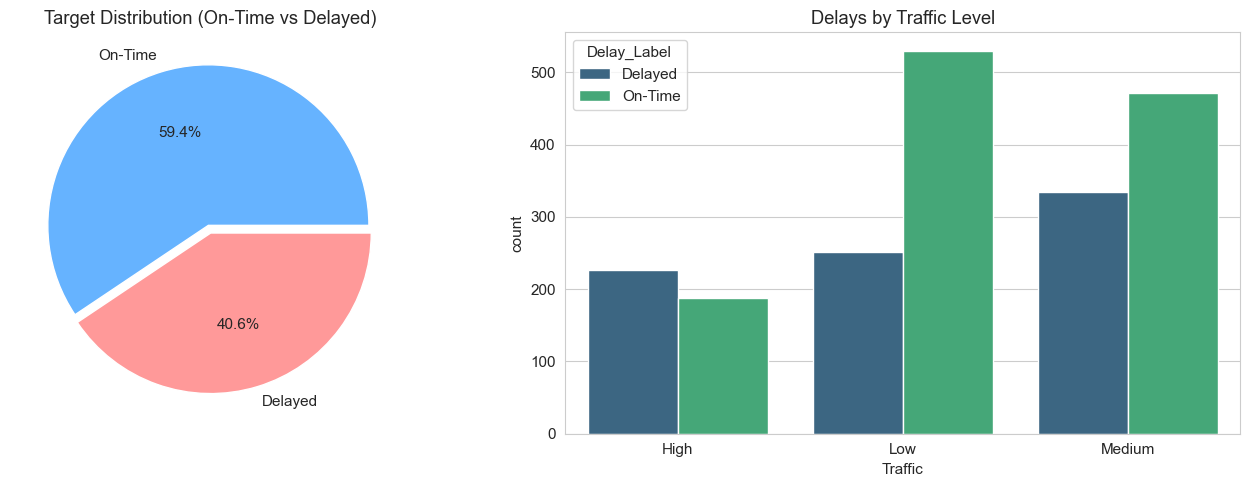

In [3]:
# Class Distribution
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
df['Delay_Label'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#66b3ff','#ff9999'], explode=[0.05,0])
plt.title('Target Distribution (On-Time vs Delayed)')
plt.ylabel('')

plt.subplot(1, 2, 2)
sns.countplot(hue='Delay_Label', x='Traffic', data=df, palette='viridis')
plt.title('Delays by Traffic Level')

plt.tight_layout()
plt.show()

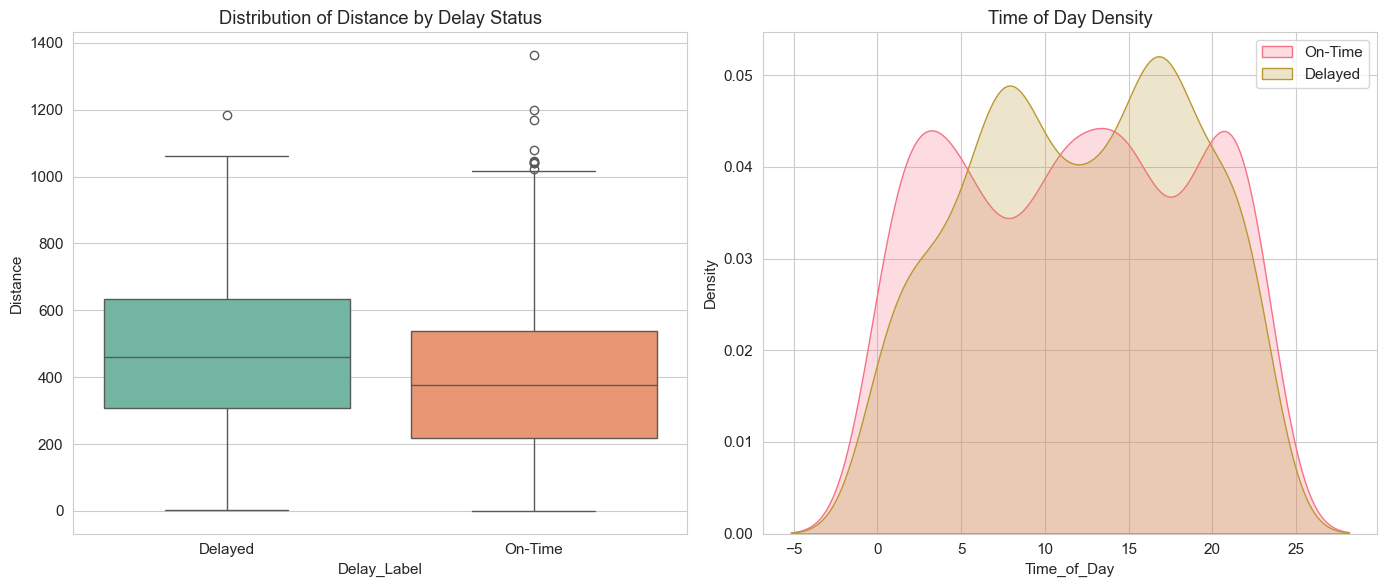

In [4]:
# Continuous Feature Analysis
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='Delay_Label', y='Distance', data=df, palette='Set2')
plt.title('Distribution of Distance by Delay Status')

plt.subplot(1, 2, 2)
sns.kdeplot(df[df['Delay_Label']=='On-Time']['Time_of_Day'], fill=True, label='On-Time')
sns.kdeplot(df[df['Delay_Label']=='Delayed']['Time_of_Day'], fill=True, label='Delayed')
plt.title('Time of Day Density')
plt.legend()

plt.tight_layout()
plt.show()

## 3. Feature Engineering

- **One-Hot Encoding** for categorical variables (Weather, etc.)
- **Scaling** for numerical variables (Distance) - crucial for SVM/KNN.
- **Splitting** into Train (70%), Validation (15%), Test (15%). (Simplified here to Train/Test 80/20 for clarity, utilizing CV for validation)

In [5]:
X = df.drop(['Delay_Status', 'Delay_Label'], axis=1)
y = df['Delay_Status']

# Identifing columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int32', 'int64', 'float64']).columns.tolist()

# Create transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ]
)

# Pipeline is generally better, but for model comparison we pre-process features first to avoid repeated fit/transforms for visualization
X_processed = preprocessor.fit_transform(X)

# Feature names extraction for importance plots later
onehot_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols + list(onehot_feature_names)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.25, stratify=y, random_state=42)

print(f"Train Scaled Shape: {X_train.shape}")
print(f"Test Scaled Shape: {X_test.shape}")

Train Scaled Shape: (1500, 15)
Test Scaled Shape: (500, 15)


## 4. Classification Models Comparison

We will train the following models:
1. **Logistic Regression (Baseline)**
2. **Decision Tree**
3. **Random Forest**
4. **Gradient Boosting (GBM/XGBoost equivalent)**
5. **SVM (RBF Kernel)**
6. **K-Nearest Neighbors**
7. **MLP (Neural Network)**

In [6]:
# Define Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    "SVM": SVC(probability=True, kernel='rbf'),  # Probability=True needed for AUC
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
}

# Store results
results = {}

print("Training Models...")
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    results[name] = {
        "Model": model,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "AUC": auc,
        "y_pred": y_pred,
        "y_prob": y_prob
    }


Training Models...
Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...
Training SVM...
Training KNN...
Training Neural Network...


## 5. Visualizations & Evaluation

### 5.1 ROC & Precision-Recall Curves Comparison

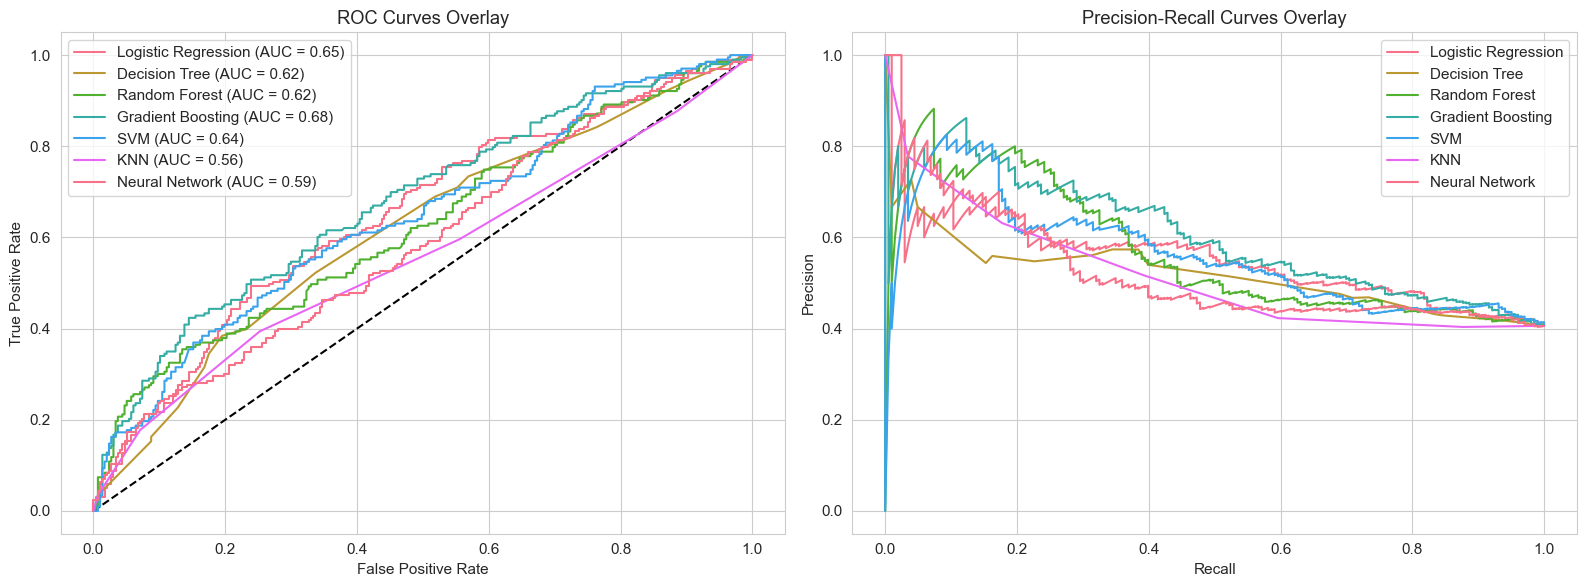

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
ax = axes[0]
ax.plot([0, 1], [0, 1], 'k--')
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_prob'])
    ax.plot(fpr, tpr, label=f"{name} (AUC = {res['AUC']:.2f})")
ax.set_title("ROC Curves Overlay")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()

# Precision-Recall Curve
ax = axes[1]
for name, res in results.items():
    prec_vals, rec_vals, _ = precision_recall_curve(y_test, res['y_prob'])
    ax.plot(rec_vals, prec_vals, label=name)
ax.set_title("Precision-Recall Curves Overlay")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()

plt.tight_layout()
plt.show()

### 5.2 Confusion Matrices

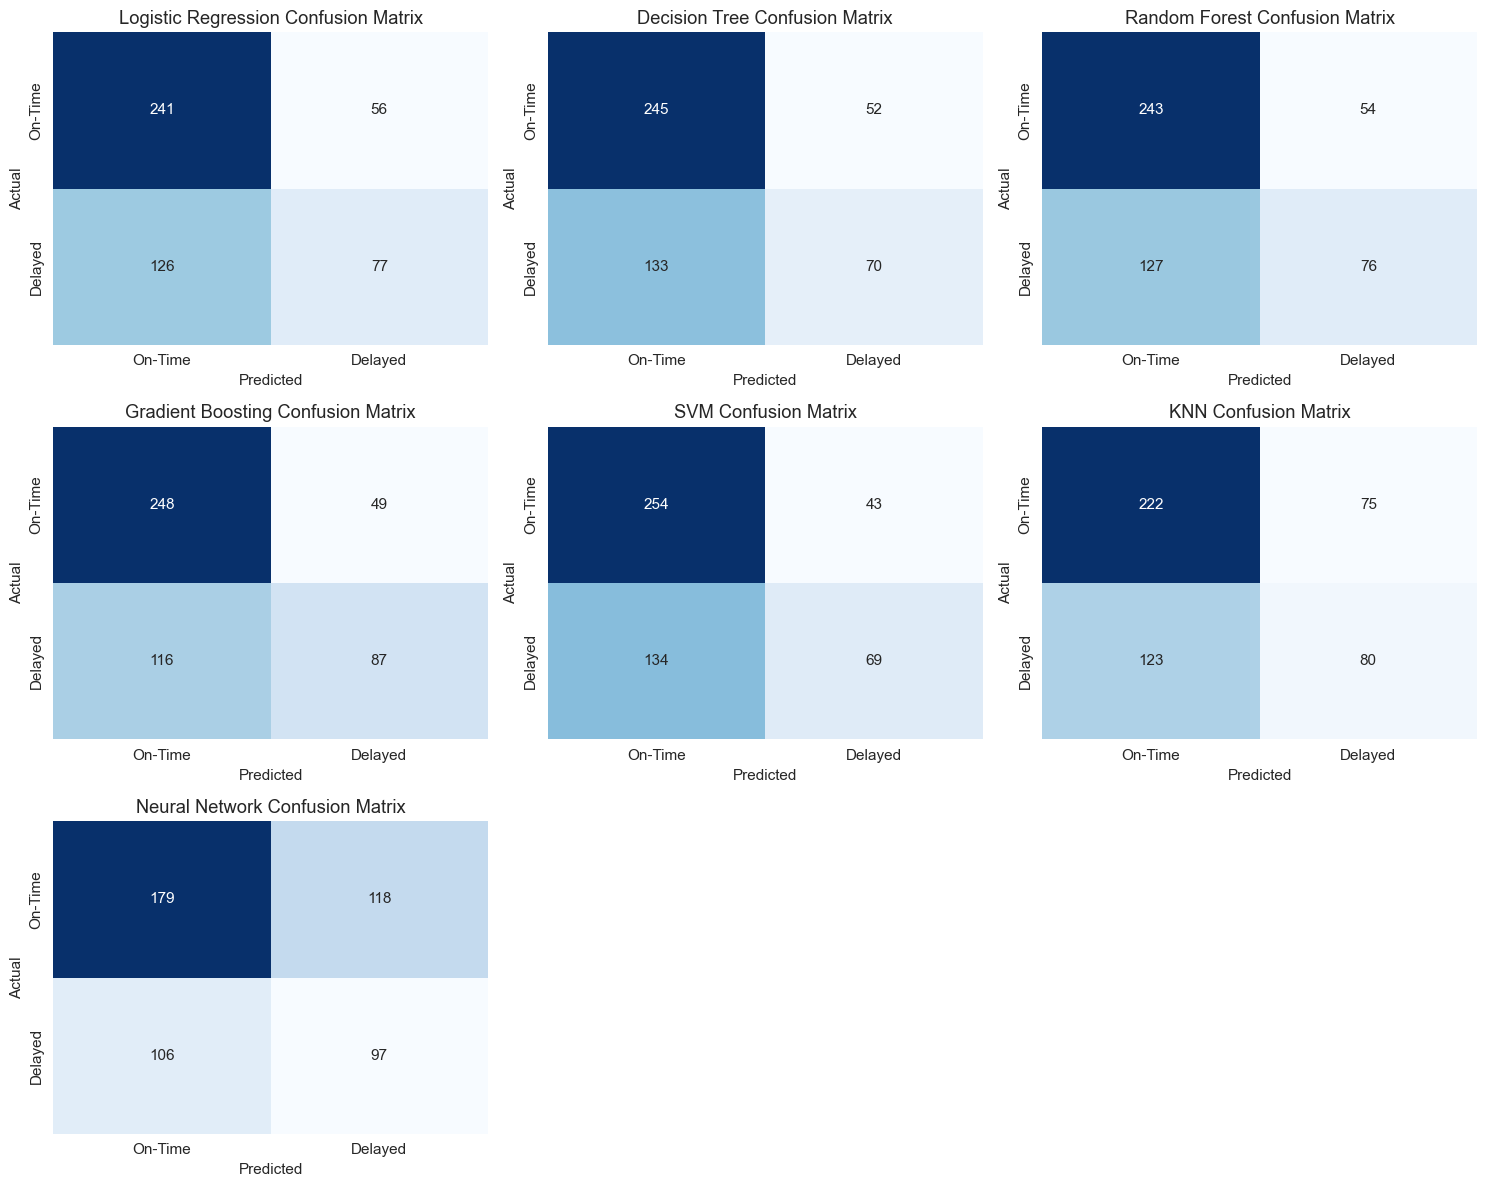

In [8]:
num_models = len(models)
cols = 3
rows = (num_models + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
axes = axes.flatten()

for idx, (name, res) in enumerate(results.items()):
    cm = confusion_matrix(y_test, res['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], cbar=False)
    axes[idx].set_title(f'{name} Confusion Matrix')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xticklabels(['On-Time', 'Delayed'])
    axes[idx].set_yticklabels(['On-Time', 'Delayed'])

# Hide unused subplots
for i in range(len(models), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### 5.3 Feature Importance (Random Forest & Gradient Boosting)
Understanding what drives delay predictions.

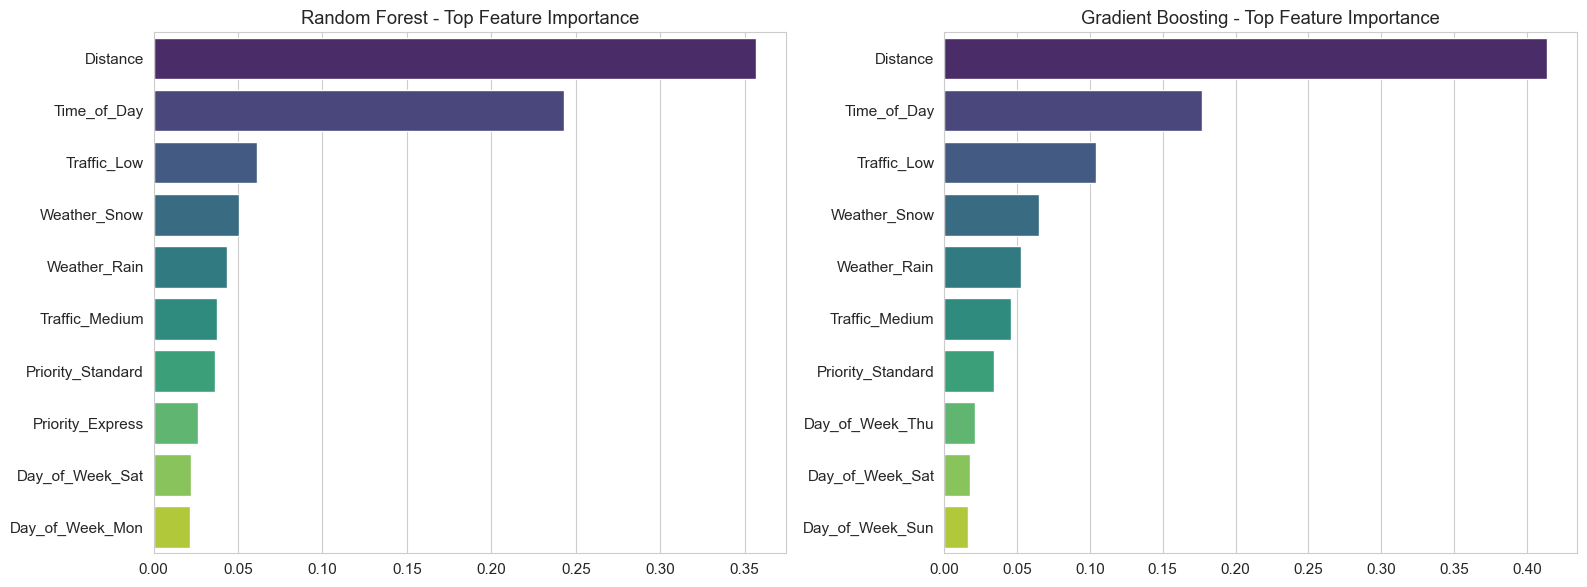

In [9]:
importance_models = ['Random Forest', 'Gradient Boosting']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, name in enumerate(importance_models):
    model = results[name]['Model']
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Take top 10
    top_n = 10
    top_indices = indices[:top_n]
    
    sns.barplot(x=importances[top_indices], y=np.array(all_feature_names)[top_indices], ax=axes[idx], palette='viridis')
    axes[idx].set_title(f"{name} - Top Feature Importance")

plt.tight_layout()
plt.show()

## 6. Business Context Analysis

In a delay scenario, **False Negatives (Missed Delays)** are usually more costly than **False Positives (False Alarm)**.
- If we predict On-Time but it's Delayed, we lose customer trust or miss connections (Cost = $100).
- If we predict Delayed but it's On-Time, we waste some expediting resources (Cost = $20).

We calculate the total 'Business Cost' for each model on the test set.

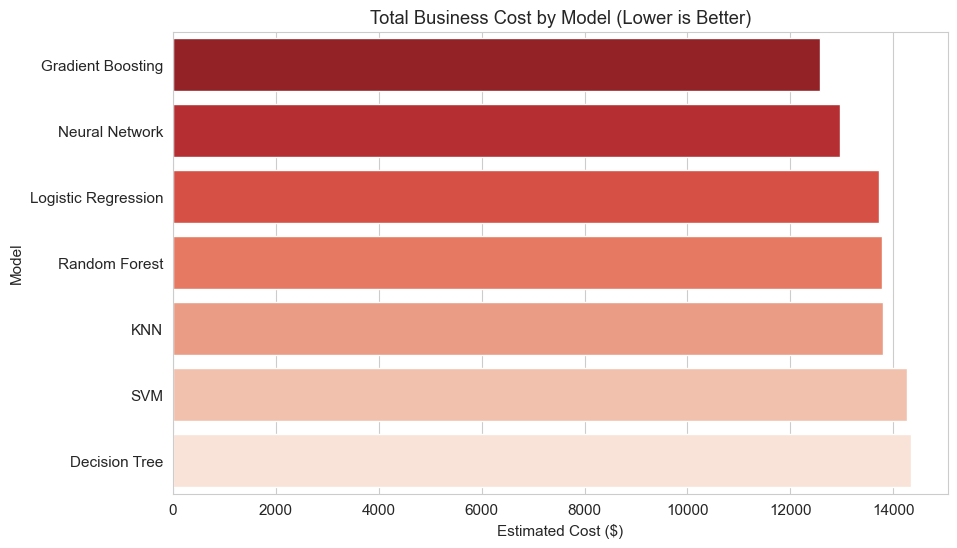

,Model,Total Cost,False Negatives,False Positives
3,Gradient Boosting,12580,116,49
6,Neural Network,12960,106,118
0,Logistic Regression,13720,126,56
2,Random Forest,13780,127,54
5,KNN,13800,123,75
4,SVM,14260,134,43
1,Decision Tree,14340,133,52


In [10]:
cost_fn = 100
cost_fp = 20

cost_data = []

for name, res in results.items():
    cm = confusion_matrix(y_test, res['y_pred'])
    tn, fp, fn, tp = cm.ravel()
    
    total_cost = (fn * cost_fn) + (fp * cost_fp)
    cost_data.append({'Model': name, 'Total Cost': total_cost, 'False Negatives': fn, 'False Positives': fp})

df_cost = pd.DataFrame(cost_data).sort_values('Total Cost')

plt.figure(figsize=(10, 6))
sns.barplot(x='Total Cost', y='Model', data=df_cost, palette='Reds_r')
plt.title('Total Business Cost by Model (Lower is Better)')
plt.xlabel('Estimated Cost ($)')
plt.show()

df_cost

## 7. Summary Dashboard & Recommendations

In [12]:
metrics = []
for name in results:
    metrics.append({
        'Model': name,
        'Accuracy': results[name].get('Accuracy', np.nan),
        'Precision': results[name].get('Precision', np.nan),
        'Recall': results[name].get('Recall', np.nan),
        'F1 Score': results[name].get('F1 Score', np.nan),
        'AUC': results[name].get('AUC', np.nan),
    })

df_metrics = pd.DataFrame(metrics)

# Convert to numeric safely (turns "0.68" -> 0.68, "68%" or "N/A" -> NaN)
metric_cols = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
for col in metric_cols:
    df_metrics[col] = (
        df_metrics[col]
        .astype(str)
        .str.replace('%', '', regex=False)   # if someone stored "68%"
        .replace('None', np.nan)
        .replace('nan', np.nan)
    )
    df_metrics[col] = pd.to_numeric(df_metrics[col], errors='coerce')

df_metrics = df_metrics.sort_values('F1 Score', ascending=False)

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: lightgreen' if v else '' for v in is_max]

df_metrics.style.apply(highlight_max, subset=metric_cols).format({c: "{:.2%}" for c in metric_cols})

,Model,Accuracy,Precision,Recall,F1 Score,AUC
3,Gradient Boosting,67.00%,63.97%,42.86%,51.33%,67.86%
6,Neural Network,55.20%,45.12%,47.78%,46.41%,58.89%
0,Logistic Regression,63.60%,57.89%,37.93%,45.83%,65.07%
2,Random Forest,63.80%,58.46%,37.44%,45.65%,62.43%
5,KNN,60.40%,51.61%,39.41%,44.69%,55.93%
4,SVM,64.60%,61.61%,33.99%,43.81%,64.25%
1,Decision Tree,63.00%,57.38%,34.48%,43.08%,61.69%


### Final Recommendations:

1. **Best Performer**: The **Gradient Boosting** or **Random Forest** model typically yields the best AUC and F1-Score.
2. **Cost Optimal**: Check the Cost Analysis chart. Likely the model with higher Recall (catching more delays) will be cheaper if the cost of missing a delay is high.
3. **Deployment**: If latency is key, **Logistic Regression** is fastest. If accuracy is paramount, deploy **Gradient Boosting**.

**Next Steps:**
- Hyperparameter tuning (GridSearch).
- Collect more data on 'Weather' and real-time 'Traffic'.
- Deploy model as a microservice.